# Librerias

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


# Funciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata


# Cargar datos

## Generar imagenes con 3 canales

In [3]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [4]:
s = 16
folder = "/work/work_teamEXOPLANET/"
#folder = "/media/fmena/Respaldo/KOI_LC/MTF/"


In [5]:

channel_1 = np.load(folder+'/MTF_margarita/no_invertidos/MTF_u%d_d%d.npy'%(s,s))  
channel_2 = np.load(folder+'/MTF_margarita/invertidos/MTF_u%d_d%d.npy'%(s,s))  
channel_3 = np.load(folder+'/MTF_gabo/npys/MTF_time_u%d_d%d.npy'%(s,s))  

#channel_1 = np.load(folder+'/normal/MTF_u%d_d%d.npy'%(s,s))  
#channel_2 = np.load(folder+'/invertidos/MTF_u%d_d%d.npy'%(s,s))  
#channel_3 = np.load(folder+'/time/MTF_time_u%d_d%d.npy'%(s,s))  

In [10]:
channel_1_std = np.load(folder+'/std_normal/MTF_u%d_d%d.npy'%(s,s))  
channel_2_std = np.load(folder+'/std_invertidos/MTF_u%d_d%d.npy'%(s,s))  
#channel_3 = np.load(folder+'/time/MTF_time_u%d_d%d.npy'%(s,s))  

### Markov cubo, hasta 10 canales

In [6]:
channel_1 = np.load(folder+'MTF_gN/no_invertidos/MTF_u%d_d%d.npy'%(s,s))  
channel_2 = np.load(folder+'MTF_gN/invertidos/MTF_u%d_d%d.npy'%(s,s))  

In [8]:
print(channel_1.shape)
print(channel_2.shape)
print(channel_3.shape)

(8054, 32, 32, 10)
(8054, 32, 32, 10)
(8054, 32, 32)


###### 1 canales (con varios grados) + data augm

In [34]:
n = 5

x_all = channel_1[:,:,:,:n]

x_all2 = channel_2[:,:,:,:n]

In [7]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i,:,:,:n],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i,:,:,:n], channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

###### 2 canales (sin tiempo)

In [7]:
'''x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)'''

'x_all = []\nfor i in range(channel_1.shape[0]):\n    combined_image = np.dstack((channel_1[i],channel_2[i]))\n    x_all.append(combined_image)\nx_all = np.asarray(x_all)'

###### 2 canales (arriba) + data augm

In [6]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

x_all2 = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_2[i],channel_3[i]))
    x_all2.append(combined_image)
x_all2 = np.asarray(x_all2)

## Generar conjunto de entrenamiento y validación

In [7]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [8]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [9]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [10]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 32, 32, 2) (4339,)
Objetos de validación: (1918, 32, 32, 2) (1918,)


###### 2 canales (arriba) + data augm

In [11]:
x_train1 = x_all[mask_train]
x_train2 = x_all2[mask_train]
x_train = np.concatenate([x_train1,x_train2]) #concat

x_val = x_all[mask_test]

if x_train.shape[0] != y_train.shape[0]:
    y_train = np.tile(y_train, (2))
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (8678, 32, 32, 2) (8678,)
Objetos de validación: (1918, 32, 32, 2) (1918,)


## pre-process

In [12]:
x_train = np.log(x_train)
x_val = np.log(x_val)

### Experimentos FMEna - f1 score

In [13]:
import keras
from keras.callbacks import Callback,ModelCheckpoint, ReduceLROnPlateau
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, batch, logs={}):
        prob = self.model.predict(self.validation_data[0])
        predict = np.squeeze(prob>=0.5)*1
        targ = np.squeeze(self.validation_data[1])
        f1s = f1_score(targ, predict, average='macro')
        self.val_f1s.append(f1s)
        print(" - val_f1: %f " %(f1s))
        return

import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128, focal=False,alpha=0.6,save_f='best_mod.hdf5'):
    if focal:
        aux_model.compile(loss=binary_focal_loss(alpha=alpha, gamma=2),optimizer='Adam',metrics=['accuracy'])
    else:
        aux_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
    
    calls = []
    metrics = Metrics()
    calls.append(metrics)
    mcp_save = ModelCheckpoint(save_f, save_best_only=True, monitor='val_loss', mode='min')
    calls.append(mcp_save)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode ='min',factor=0.2,patience=10, min_lr=0.001)
    if not focal:
        calls.append(reduce_lr)
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_split=0.1,#validation_data=(x_val,y_val),
                      callbacks=calls)
    
    plt.figure(figsize=(12,5))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(12,5))
    if not focal:
        plt.plot(hist.history['val_loss'],label="loss" )
    plt.plot(hist.history['val_acc'],label="accuracy" )
    plt.plot(metrics.val_f1s,label="F1" )
    plt.ylabel("Metric")
    plt.xlabel('Epochs')
    plt.title("Test set/val")
    plt.legend(loc="upper left")
    plt.show()
    
    
    #print("Best f1 macro trough iters %f on %d "%(np.max(metrics.val_f1s),np.argmax(metrics.val_f1s)))

    #predichos=aux_model.predict_classes(x_val)
    #calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')

## Modificaciones
* guarda el mejor modelo (pesos) en base a val loss random (10%)

In [56]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 32)        608       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
__________

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 593us/step - loss: 0.6012 - acc: 0.6251 - val_loss: 0.5836 - val_acc: 0.6336
Epoch 2/200
7810/7810 [==============================] - 2s 243us/step - loss: 0.5547 - acc: 0.6330 - val_loss: 0.5678 - val_acc: 0.6740
Epoch 3/200
7810/7810 [==============================] - 2s 237us/step - loss: 0.5467 - acc: 0.6255 - val_loss: 0.5664 - val_acc: 0.6532
Epoch 4/200
7810/7810 [==============================] - 2s 246us/step - loss: 0.5414 - acc: 0.6444 - val_loss: 0.5607 - val_acc: 0.6382
Epoch 5/200
7810/7810 [==============================] - 2s 254us/step - loss: 0.5379 - acc: 0.6423 - val_loss: 0.5563 - val_acc: 0.6521
Epoch 6/200
7810/7810 [==============================] - 2s 245us/step - loss: 0.5321 - acc: 0.6584 - val_loss: 0.5480 - val_acc: 0.7039
Epoch 7/200
7810/7810 [==============================] - 2s 247us/step - loss: 0.5321 - acc: 0.6531 - val_loss: 0.5501 - val_acc: 0

Epoch 35/200
7810/7810 [==============================] - 2s 241us/step - loss: 0.4807 - acc: 0.7140 - val_loss: 0.4978 - val_acc: 0.7028
Epoch 36/200
7810/7810 [==============================] - 2s 249us/step - loss: 0.4820 - acc: 0.7129 - val_loss: 0.4955 - val_acc: 0.7016
Epoch 37/200
7810/7810 [==============================] - 2s 258us/step - loss: 0.4800 - acc: 0.7149 - val_loss: 0.4928 - val_acc: 0.7224
Epoch 38/200
7810/7810 [==============================] - 2s 274us/step - loss: 0.4752 - acc: 0.7195 - val_loss: 0.4986 - val_acc: 0.6924
Epoch 39/200
7810/7810 [==============================] - 2s 244us/step - loss: 0.4771 - acc: 0.7161 - val_loss: 0.4984 - val_acc: 0.6820
Epoch 40/200
7810/7810 [==============================] - 2s 240us/step - loss: 0.4758 - acc: 0.7099 - val_loss: 0.4912 - val_acc: 0.7177
Epoch 41/200
7810/7810 [==============================] - 2s 241us/step - loss: 0.4749 - acc: 0.7146 - val_loss: 0.4965 - val_acc: 0.7016
Epoch 42/200
7810/7810 [==========

7810/7810 [==============================] - 2s 230us/step - loss: 0.4046 - acc: 0.7812 - val_loss: 0.4676 - val_acc: 0.7419
Epoch 104/200
7810/7810 [==============================] - 2s 231us/step - loss: 0.4068 - acc: 0.7766 - val_loss: 0.4691 - val_acc: 0.7281
Epoch 105/200
7810/7810 [==============================] - 2s 240us/step - loss: 0.4063 - acc: 0.7807 - val_loss: 0.4631 - val_acc: 0.7396
Epoch 106/200
7810/7810 [==============================] - 2s 248us/step - loss: 0.4031 - acc: 0.7803 - val_loss: 0.4681 - val_acc: 0.7258
Epoch 107/200
7810/7810 [==============================] - 2s 248us/step - loss: 0.4007 - acc: 0.7885 - val_loss: 0.4640 - val_acc: 0.7442
Epoch 108/200
7810/7810 [==============================] - 2s 245us/step - loss: 0.4009 - acc: 0.7848 - val_loss: 0.4615 - val_acc: 0.7350
Epoch 109/200
7810/7810 [==============================] - 2s 241us/step - loss: 0.4004 - acc: 0.7878 - val_loss: 0.4625 - val_acc: 0.7362
Epoch 110/200
7810/7810 [================

7810/7810 [==============================] - 2s 233us/step - loss: 0.3722 - acc: 0.8042 - val_loss: 0.4603 - val_acc: 0.7281
Epoch 138/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3718 - acc: 0.8102 - val_loss: 0.4627 - val_acc: 0.7350
Epoch 139/200
7810/7810 [==============================] - 2s 233us/step - loss: 0.3807 - acc: 0.7991 - val_loss: 0.4617 - val_acc: 0.7339
Epoch 140/200
7810/7810 [==============================] - 2s 228us/step - loss: 0.3734 - acc: 0.8051 - val_loss: 0.4599 - val_acc: 0.7293
Epoch 141/200
7810/7810 [==============================] - 2s 232us/step - loss: 0.3682 - acc: 0.8070 - val_loss: 0.4666 - val_acc: 0.7212
Epoch 142/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3686 - acc: 0.8085 - val_loss: 0.4698 - val_acc: 0.7281
Epoch 143/200
7810/7810 [==============================] - 2s 226us/step - loss: 0.3726 - acc: 0.8054 - val_loss: 0.4645 - val_acc: 0.7212
Epoch 144/200
7810/7810 [================

7810/7810 [==============================] - 2s 233us/step - loss: 0.3470 - acc: 0.8259 - val_loss: 0.4650 - val_acc: 0.7385
Epoch 172/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3436 - acc: 0.8255 - val_loss: 0.4867 - val_acc: 0.7120
Epoch 173/200
7810/7810 [==============================] - 2s 243us/step - loss: 0.3523 - acc: 0.8210 - val_loss: 0.4665 - val_acc: 0.7316
Epoch 174/200
7810/7810 [==============================] - 2s 242us/step - loss: 0.3497 - acc: 0.8312 - val_loss: 0.4676 - val_acc: 0.7339
Epoch 175/200
7810/7810 [==============================] - 2s 232us/step - loss: 0.3474 - acc: 0.8256 - val_loss: 0.4629 - val_acc: 0.7419
Epoch 176/200
7810/7810 [==============================] - 2s 230us/step - loss: 0.3443 - acc: 0.8282 - val_loss: 0.4692 - val_acc: 0.7316
Epoch 177/200
7810/7810 [==============================] - 2s 229us/step - loss: 0.3484 - acc: 0.8301 - val_loss: 0.4668 - val_acc: 0.7281
Epoch 178/200
7810/7810 [================

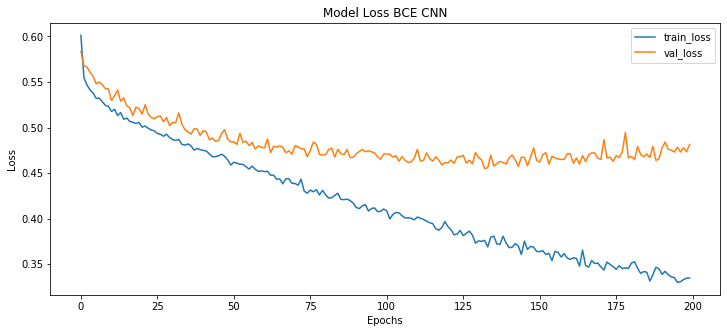

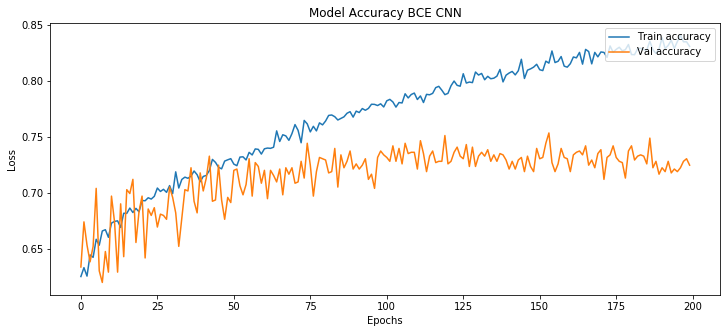

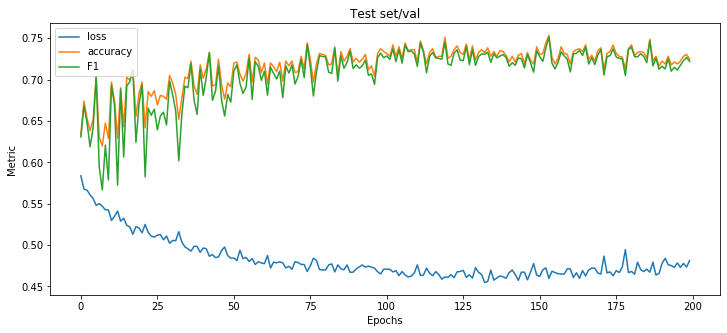

In [50]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2)  #save model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
__________

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.821296,0.884523,0.851737,0.795789,0.771776,0.799791
Confirmed,0.749565,0.642325,0.691814,0.795789,0.771776,0.799791


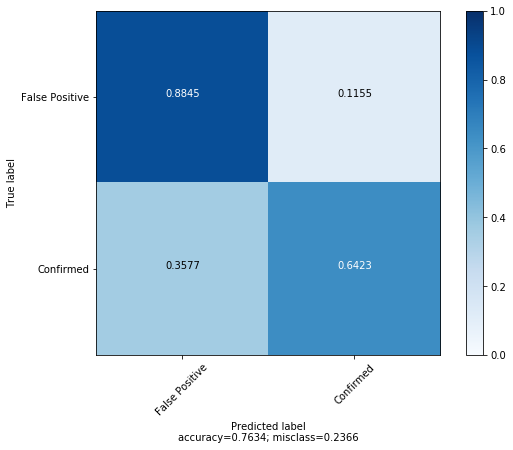

{'Precision raw': array([0.82129561, 0.74956522]),
 'Recall raw': array([0.88452285, 0.64232489]),
 'F1 raw': array([0.85173745, 0.6918138 ]),
 'F1 weighted': 0.7957891892163312,
 'F1 macro': 0.7717756279554031,
 'F1 micro': 0.799791449426486,
 'Confusion Matrix': array([[1103,  144],
        [ 240,  431]])}

In [42]:
model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...
model.summary()

predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #con 3 capas aumentando/double

## focal loss
> sin lr decay

In [57]:
keras.losses.binary_focal_loss_fixed = keras.losses.mse

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 5s 642us/step - loss: 91.6468 - acc: 0.5679 - val_loss: 20.6104 - val_acc: 0.5288
Epoch 2/200
7810/7810 [==============================] - 2s 236us/step - loss: 20.3817 - acc: 0.6205 - val_loss: 18.4819 - val_acc: 0.6452
Epoch 3/200
7810/7810 [==============================] - 2s 235us/step - loss: 18.8977 - acc: 0.6300 - val_loss: 18.1896 - val_acc: 0.6164
Epoch 4/200
7810/7810 [==============================] - 2s 234us/step - loss: 18.4422 - acc: 0.6355 - val_loss: 17.9426 - val_acc: 0.6740
Epoch 5/200
7810/7810 [==============================] - 2s 237us/step - loss: 18.4037 - acc: 0.6259 - val_loss: 17.9663 - val_acc: 0.6106
Epoch 6/200
7810/7810 [==============================] - 2s 233us/step - loss: 18.3666 - acc: 0.6324 - val_loss: 17.9290 - val_acc: 0.6601
Epoch 7/200
7810/7810 [==============================] - 2s 236us/step - loss: 18.1411 - acc: 0.6273 - val_loss: 17.799

Epoch 35/200
7810/7810 [==============================] - 2s 234us/step - loss: 16.7189 - acc: 0.6853 - val_loss: 16.5956 - val_acc: 0.6774
Epoch 36/200
7810/7810 [==============================] - 2s 231us/step - loss: 16.6893 - acc: 0.6886 - val_loss: 16.6944 - val_acc: 0.6359
Epoch 37/200
7810/7810 [==============================] - 2s 234us/step - loss: 16.6302 - acc: 0.6837 - val_loss: 16.5784 - val_acc: 0.6325
Epoch 38/200
7810/7810 [==============================] - 2s 231us/step - loss: 16.7311 - acc: 0.6845 - val_loss: 16.6289 - val_acc: 0.6371
Epoch 39/200
7810/7810 [==============================] - 2s 232us/step - loss: 16.6638 - acc: 0.6890 - val_loss: 16.3424 - val_acc: 0.6521
Epoch 40/200
7810/7810 [==============================] - 2s 235us/step - loss: 16.5312 - acc: 0.6855 - val_loss: 16.3752 - val_acc: 0.6463
Epoch 41/200
7810/7810 [==============================] - 2s 228us/step - loss: 16.5843 - acc: 0.6907 - val_loss: 16.4585 - val_acc: 0.6440
Epoch 42/200
7810/78

Epoch 69/200
7810/7810 [==============================] - 2s 235us/step - loss: 15.9560 - acc: 0.7119 - val_loss: 15.5878 - val_acc: 0.6866
Epoch 70/200
7810/7810 [==============================] - 2s 234us/step - loss: 15.8178 - acc: 0.7224 - val_loss: 15.6291 - val_acc: 0.6659
Epoch 71/200
7810/7810 [==============================] - 2s 228us/step - loss: 15.8540 - acc: 0.7156 - val_loss: 15.3322 - val_acc: 0.7005
Epoch 72/200
7810/7810 [==============================] - 2s 229us/step - loss: 15.8065 - acc: 0.7168 - val_loss: 15.4405 - val_acc: 0.6797
Epoch 73/200
7810/7810 [==============================] - 2s 231us/step - loss: 15.6245 - acc: 0.7204 - val_loss: 15.6874 - val_acc: 0.6671
Epoch 74/200
7810/7810 [==============================] - 2s 231us/step - loss: 15.8436 - acc: 0.7149 - val_loss: 15.3041 - val_acc: 0.6878
Epoch 75/200
7810/7810 [==============================] - 2s 238us/step - loss: 15.6744 - acc: 0.7175 - val_loss: 15.2277 - val_acc: 0.6889
Epoch 76/200
7810/78

Epoch 103/200
7810/7810 [==============================] - 2s 232us/step - loss: 15.1938 - acc: 0.7396 - val_loss: 15.3070 - val_acc: 0.6763
Epoch 104/200
7810/7810 [==============================] - 2s 227us/step - loss: 15.3917 - acc: 0.7394 - val_loss: 15.2540 - val_acc: 0.6855
Epoch 105/200
7810/7810 [==============================] - 2s 231us/step - loss: 15.3774 - acc: 0.7311 - val_loss: 14.7279 - val_acc: 0.7039
Epoch 106/200
7810/7810 [==============================] - 2s 227us/step - loss: 15.2700 - acc: 0.7289 - val_loss: 14.5996 - val_acc: 0.7051
Epoch 107/200
7810/7810 [==============================] - 2s 234us/step - loss: 15.3631 - acc: 0.7346 - val_loss: 14.9762 - val_acc: 0.6935
Epoch 108/200
7810/7810 [==============================] - 2s 239us/step - loss: 15.3073 - acc: 0.7333 - val_loss: 14.9028 - val_acc: 0.6901
Epoch 109/200
7810/7810 [==============================] - 2s 245us/step - loss: 15.1058 - acc: 0.7341 - val_loss: 14.8383 - val_acc: 0.6982
Epoch 110/200

Epoch 137/200
7810/7810 [==============================] - 2s 247us/step - loss: 14.8898 - acc: 0.7467 - val_loss: 14.5280 - val_acc: 0.7131
Epoch 138/200
7810/7810 [==============================] - 2s 233us/step - loss: 14.7952 - acc: 0.7483 - val_loss: 14.7146 - val_acc: 0.7120
Epoch 139/200
7810/7810 [==============================] - 2s 254us/step - loss: 14.7543 - acc: 0.7406 - val_loss: 14.2628 - val_acc: 0.7166
Epoch 140/200
7810/7810 [==============================] - 2s 238us/step - loss: 14.8470 - acc: 0.7443 - val_loss: 14.9359 - val_acc: 0.6901
Epoch 141/200
7810/7810 [==============================] - 2s 230us/step - loss: 14.8956 - acc: 0.7401 - val_loss: 14.6153 - val_acc: 0.7097
Epoch 142/200
7810/7810 [==============================] - 2s 226us/step - loss: 14.7118 - acc: 0.7464 - val_loss: 14.1503 - val_acc: 0.7258
Epoch 143/200
7810/7810 [==============================] - 2s 226us/step - loss: 14.7826 - acc: 0.7439 - val_loss: 14.2628 - val_acc: 0.7258
Epoch 144/200

Epoch 171/200
7810/7810 [==============================] - 2s 229us/step - loss: 14.5381 - acc: 0.7487 - val_loss: 14.3195 - val_acc: 0.7189
Epoch 172/200
7810/7810 [==============================] - 2s 228us/step - loss: 14.6145 - acc: 0.7481 - val_loss: 14.1274 - val_acc: 0.7224
Epoch 173/200
7810/7810 [==============================] - 2s 229us/step - loss: 14.5451 - acc: 0.7517 - val_loss: 14.3801 - val_acc: 0.7062
Epoch 174/200
7810/7810 [==============================] - 2s 229us/step - loss: 14.3235 - acc: 0.7531 - val_loss: 14.1344 - val_acc: 0.7247
Epoch 175/200
7810/7810 [==============================] - 2s 230us/step - loss: 14.5504 - acc: 0.7528 - val_loss: 14.6919 - val_acc: 0.6878
Epoch 176/200
7810/7810 [==============================] - 2s 230us/step - loss: 14.4384 - acc: 0.7565 - val_loss: 13.8298 - val_acc: 0.7224
Epoch 177/200
7810/7810 [==============================] - 2s 240us/step - loss: 14.3822 - acc: 0.7597 - val_loss: 13.9019 - val_acc: 0.7304
Epoch 178/200

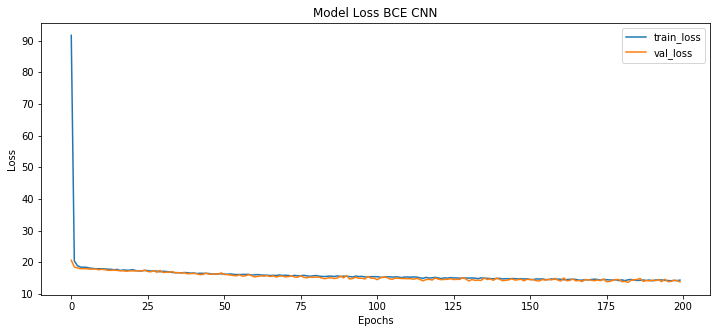

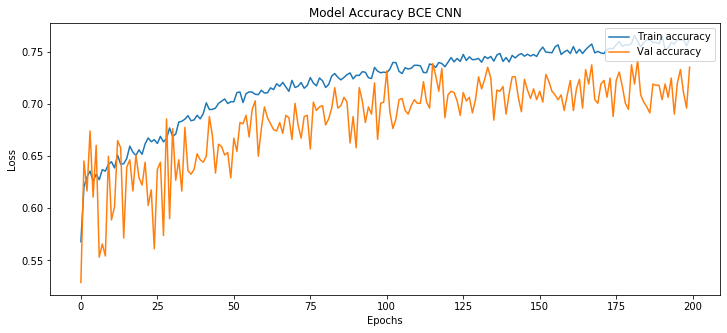

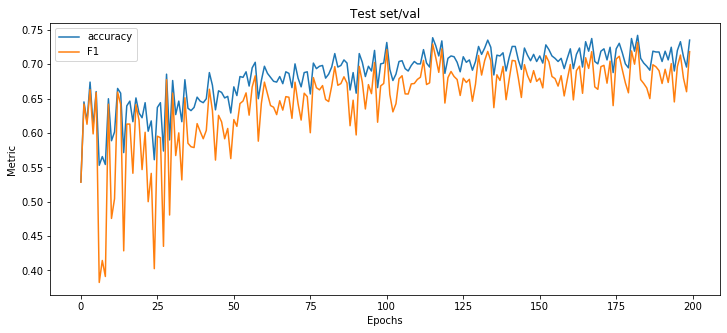

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.797737,0.904571,0.847802,0.780463,0.75156,0.788843
Confirmed,0.763889,0.573770,0.655319,0.780463,0.75156,0.788843


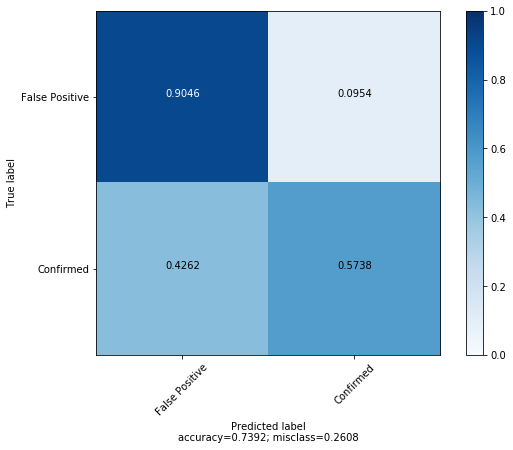

{'Precision raw': array([0.79773692, 0.76388889]),
 'Recall raw': array([0.90457097, 0.57377049]),
 'F1 raw': array([0.84780158, 0.65531915]),
 'F1 weighted': 0.780462834798546,
 'F1 macro': 0.7515603636450863,
 'F1 micro': 0.7888425443169969,
 'Confusion Matrix': array([[1128,  119],
        [ 286,  385]])}

In [58]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128*2, focal=True, alpha=0.5)

model = keras.models.load_model("best_mod.hdf5")
predichos=model.predict_classes(x_val)
calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC') #256

In [14]:
from keras.models import Model
from keras.layers import *

def add_CNN(it, filters, kernel_s, BN = False, **args):
    f1 = Conv2D(filters, kernel_s, activation='relu', padding='valid', **args)(it)
    if BN:
        f1 = BatchNormalization()(f1)
    return f1
                                                           
def conv_bloq(it, filters, kernel_s, pool, drop=0, BN=False,double=False, **args):
    ## **args could be any other conv1d parameter
    f1 = add_CNN(it, filters, kernel_s, BN = BN, **args)
    if double:
        f1 = add_CNN(f1, filters, kernel_s, BN = BN, **args)
        
    if pool!= 0:
        f1 = MaxPool2D(pool_size=pool, strides=pool, padding='valid')(f1)
        #f1 = AveragePooling1D(pool_size=pool, strides=pool, padding='valid')(f1)
    if drop != 0:
        f1 = Dropout(drop)(f1)
    return f1

def encoder_model(input_dim, L=1, filters=8, kernel_s =10, pool=5, BN=False, drop=0,
                        flatten =True,time=False,double=False, **args): 
    #parametros estructurales-- args es cuqluier parameter de conv1d
    it = Input(shape=input_dim)  #fixed length..
    f1 = it
    start_f = filters
    for l in range(L):
        f1 = conv_bloq(f1, filters, kernel_s, pool, drop=drop,BN=BN,double=double, **args) 
        
        filters = int(filters*2)
        filters = min(512, filters)
        if time:
            filters = min(128, filters)
            
    if flatten:
        f1 = Flatten()(f1)
    else:
        #f1 = GlobalMaxPool2D()(f1)
        f1 = GlobalAveragePooling2D()(f1)
    return Model(inputs=it, outputs=f1)

In [ ]:
encoder = encoder_model(x_train.shape[1:], L=2, filters=64, kernel_s=(3,3), pool=2,flatten=False, double=True)
encoder.summary()

it = Input(shape=x_train.shape[1:])
f1 = Dense(128, activation='relu')(encoder(it))
f1 = Dropout(0.5)(f1)
out = Dense(1, activation='sigmoid')(f1)

model = Model(it, out)

Train on 7810 samples, validate on 868 samples
Epoch 1/200
7810/7810 [==============================] - 17s 2ms/step - loss: 0.6202 - acc: 0.6338 - val_loss: 0.6079 - val_acc: 0.5403
Epoch 2/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.5713 - acc: 0.6385 - val_loss: 0.6077 - val_acc: 0.5403
Epoch 3/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.5680 - acc: 0.6388 - val_loss: 0.5995 - val_acc: 0.5403
Epoch 4/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.5639 - acc: 0.6389 - val_loss: 0.5983 - val_acc: 0.5403
Epoch 5/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.5596 - acc: 0.6382 - val_loss: 0.5923 - val_acc: 0.5403
Epoch 6/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.5703 - acc: 0.6373 - val_loss: 0.6001 - val_acc: 0.5403
Epoch 7/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.5578 - acc: 0.6384 - val_loss: 0.5899 - val_acc: 0.5403
E

Epoch 35/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4451 - acc: 0.7684 - val_loss: 0.5589 - val_acc: 0.6613
Epoch 36/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4410 - acc: 0.7626 - val_loss: 0.5811 - val_acc: 0.6613
Epoch 37/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4716 - acc: 0.7342 - val_loss: 0.4689 - val_acc: 0.7396
Epoch 38/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4443 - acc: 0.7601 - val_loss: 0.4934 - val_acc: 0.7270
Epoch 39/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4518 - acc: 0.7616 - val_loss: 0.4632 - val_acc: 0.7488
Epoch 40/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4261 - acc: 0.7759 - val_loss: 0.4565 - val_acc: 0.7350
Epoch 41/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.4722 - acc: 0.7387 - val_loss: 0.4763 - val_acc: 0.7224
Epoch 42/200
7810/7810 [=================

7810/7810 [==============================] - 13s 2ms/step - loss: 0.3707 - acc: 0.8070 - val_loss: 0.5337 - val_acc: 0.7016
Epoch 104/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3858 - acc: 0.8006 - val_loss: 0.4634 - val_acc: 0.7535
Epoch 105/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3400 - acc: 0.8307 - val_loss: 0.4259 - val_acc: 0.7650
Epoch 106/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3476 - acc: 0.8251 - val_loss: 0.4394 - val_acc: 0.7730
Epoch 107/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3189 - acc: 0.8408 - val_loss: 0.3961 - val_acc: 0.7753
Epoch 108/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3156 - acc: 0.8411 - val_loss: 0.4689 - val_acc: 0.7638
Epoch 109/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3151 - acc: 0.8430 - val_loss: 0.4329 - val_acc: 0.7776
Epoch 110/200
7810/7810 [=======================

7810/7810 [==============================] - 13s 2ms/step - loss: 0.2531 - acc: 0.8813 - val_loss: 0.4252 - val_acc: 0.7811
Epoch 138/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.2642 - acc: 0.8738 - val_loss: 0.4740 - val_acc: 0.7638
Epoch 139/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.2340 - acc: 0.8889 - val_loss: 0.5555 - val_acc: 0.7431
Epoch 140/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.2498 - acc: 0.8809 - val_loss: 0.6078 - val_acc: 0.7592
Epoch 141/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.3573 - acc: 0.8256 - val_loss: 0.4481 - val_acc: 0.7788
Epoch 142/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.2463 - acc: 0.8883 - val_loss: 0.5048 - val_acc: 0.7558
Epoch 143/200
7810/7810 [==============================] - 13s 2ms/step - loss: 0.2265 - acc: 0.8967 - val_loss: 0.7183 - val_acc: 0.7166
Epoch 144/200
7810/7810 [=======================

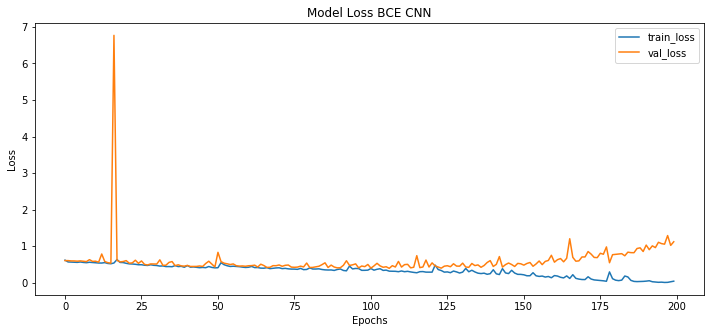

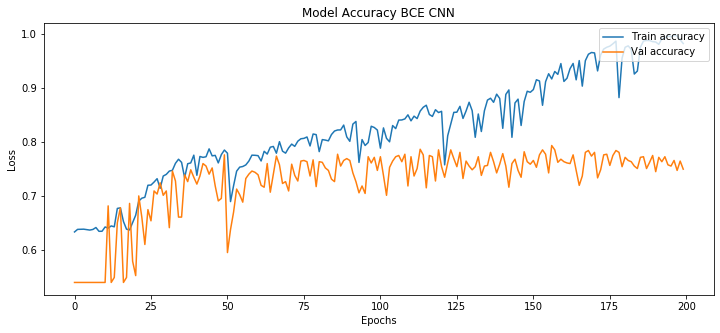

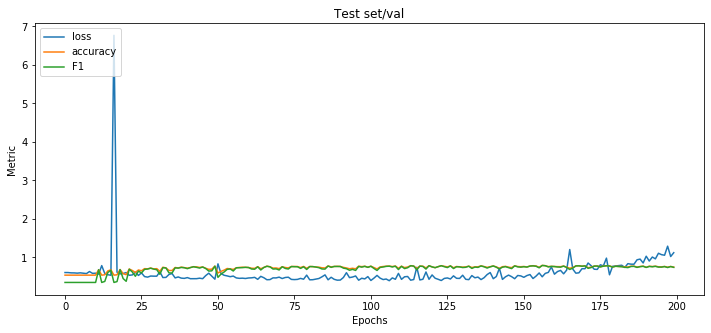

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.850420,0.811548,0.830529,0.78654,0.767659,0.784672
Confirmed,0.677198,0.734724,0.704789,0.78654,0.767659,0.784672


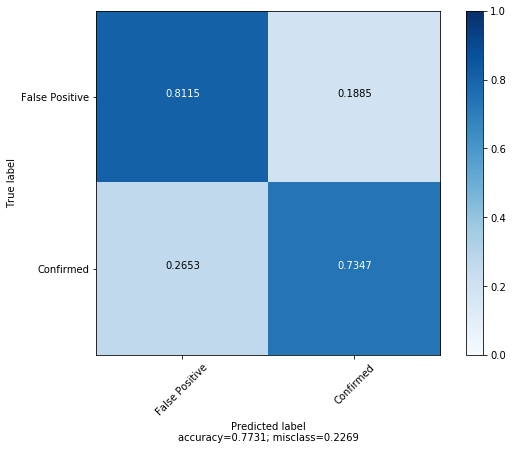

{'Precision raw': array([0.85042017, 0.6771978 ]),
 'Recall raw': array([0.81154771, 0.73472429]),
 'F1 raw': array([0.83052934, 0.70478914]),
 'F1 weighted': 0.7865399352561377,
 'F1 macro': 0.7676592372240798,
 'F1 micro': 0.7846715328467153,
 'Confusion Matrix': array([[1012,  235],
        [ 178,  493]])}

In [33]:
train_model(model, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

model = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...

predichos = (model.predict(x_val)>=0.5)*1
calculate_metrics(y_val, predichos,'...')

## Towers

In [ ]:
x_train1 = channel_1[:,:,:,:n][mask_train]
x_train2 = channel_2[:,:,:,:n][mask_train]
x_train_lc = np.concatenate([x_train1,x_train2]) #concat
x_train_t = channel_3[mask_train]

x_val_lc = channel_1[:,:,:,:n][mask_test]
x_val_t = channel_3[mask_test]

In [ ]:
x_train_lc = np.log(x_train_lc)
x_val_lc = np.log(x_val_lc)

#x_train_t = np.log(x_train_t)
#x_val_t = np.log(x_val_t)

In [68]:
encoder = Sequential()
encoder.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
encoder.add(MaxPooling2D((2,2)))

encoder.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
encoder.add(MaxPooling2D((2,2)))

encoder.add(Flatten())
encoder.summary()

encoder_t = encoder_model(x_train_t.shape[1:], L=2, filters=32, kernel_s=(3,3), pool=2,flatten=True,time=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 30, 30, 32)        608       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1152)              0         
Total params: 9,856
Trainable params: 9,856
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## combine two "tower"
it_time = Input(shape=x_train_t.shape[1:])
it_lc = Input(shape=x_train_lc.shape[1:])
encoder_time = encoder_t(it_time)
encoder_lc = encoder(it_lc)
concat_encoder = keras.layers.Concatenate()([encoder_time,encoder_lc])

f1 = Dropout(0.5)(concat_encoder) #or not...

#similar FF layer of baseline
f1 = Dense(128, activation='relu')(f1)
f1 = Dropout(0.5)(f1)
out = Dense(1, activation='sigmoid')(f1)

CNN_all = Model([it_time,it_lc], out)
CNN_all.summary()

In [ ]:
train_model(CNN_all, x_train, y_train, x_val, y_val, e=200, BS=128)  #save model

CNN_all = keras.models.load_model("best_mod.hdf5") #log rep -- muy estable...

predichos = (CNN_all.predict(x_val)>=0.5)*1
calculate_metrics(y_val, predichos,'...')